In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from LSTM import *
from LSTMbis import *
import pandas as pd
import numpy as np
import torch.utils.data as utils
import time
import os
import pickle

import pdb

# For the notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

torch.manual_seed(1)

## TRAIN SET

In [2]:
gt_train_coord = pickle.load( open( "./import_dataset_2/train/gt_train_coord.pkl", "rb" ) )
gt_train  = pickle.load( open( "./import_dataset_2/train/gt_train.pkl", "rb" ) )
in_train_coord  = pickle.load( open( "./import_dataset_2/train/in_train_coord.pkl", "rb" ) )
inputs_train = pickle.load( open( "./import_dataset_2/train/inputs_train.pkl", "rb" ) )

inputs_train = torch.from_numpy(inputs_train).float()
gt_train = torch.from_numpy(gt_train).float()
gt_train_coord.shape,gt_train.shape,in_train_coord.shape,inputs_train.shape

((11, 5157, 2),
 torch.Size([5157, 11, 4]),
 (10, 5157, 2),
 torch.Size([5157, 10, 164]))

## VALIDATION SET

In [5]:
gt_validation_coord = pickle.load( open( "./import_dataset_2/validation/gt_validation_coord.pkl", "rb" ) )
gt_validation = pickle.load( open( "./import_dataset_2/validation/gt_validation.pkl", "rb" ) )
in_validation_coord = pickle.load( open( "./import_dataset_2/validation/in_validation_coord.pkl", "rb" ) )
inputs_validation = pickle.load( open( "./import_dataset_2/validation/inputs_validation.pkl", "rb" ) )

inputs_validation = torch.from_numpy(inputs_validation).float()
gt_validation = torch.from_numpy(gt_validation).float()

gt_validation_coord.shape,gt_validation.shape,in_validation_coord.shape,inputs_validation.shape

((11, 1719, 2),
 torch.Size([1719, 11, 4]),
 (10, 1719, 2),
 torch.Size([1719, 10, 164]))

## TEST SET

In [15]:
gt_test_coord_1 = pickle.load( open( "./import_dataset_2/test/gt_test_coord_1.pkl", "rb" ) )
gt_test_1 = pickle.load( open( "./import_dataset_2/test/gt_test_1.pkl", "rb" ) )
in_test_coord_1 = pickle.load( open( "./import_dataset_2/test/in_test_coord_1.pkl", "rb" ) )
inputs_test_1 = pickle.load( open( "./import_dataset_2/test/inputs_test_1.pkl", "rb" ) )

gt_test_coord_2 = pickle.load( open( "./import_dataset_2/test/gt_test_coord_2.pkl", "rb" ) )
gt_test_2 = pickle.load( open( "./import_dataset_2/test/gt_test_2.pkl", "rb" ) )
in_test_coord_2 = pickle.load( open( "./import_dataset_2/test/in_test_coord_2.pkl", "rb" ) )
inputs_test_2 = pickle.load( open( "./import_dataset_2/test/inputs_test_2.pkl", "rb" ) )

gt_test_coord_3 = pickle.load( open( "./import_dataset_2/test/gt_test_coord_3.pkl", "rb" ) )
gt_test_3 = pickle.load( open( "./import_dataset_2/test/gt_test_3.pkl", "rb" ) )
in_test_coord_3 = pickle.load( open( "./import_dataset_2/test/in_test_coord_3.pkl", "rb" ) )
inputs_test_3 = pickle.load( open( "./import_dataset_2/test/inputs_test_3.pkl", "rb" ) )

inputs_test_1 = torch.from_numpy(inputs_test_1).float()
gt_test_1 = torch.from_numpy(gt_test_1).float()

inputs_test_2 = torch.from_numpy(inputs_test_2).float()
gt_test_2 = torch.from_numpy(gt_test_2).float()

inputs_test_3 = torch.from_numpy(inputs_test_3).float()
gt_test_3 = torch.from_numpy(gt_test_3).float()
inputs_test_1.shape

torch.Size([10, 251, 164])

### Model

In [8]:
from torch import optim

inp_size = np.int(inputs_train.shape[2]/4)
lr = 0.01
lstm = LSTM(4*inp_size,4,num_layers=2,hidden_size=128)
optimizer = optim.Adam(lstm.parameters(), lr=lr,weight_decay=1e-4)
criterion = nn.MSELoss()

In [9]:
traindataset = utils.TensorDataset(inputs_train, gt_train[:,1:,:])
trainloader = utils.DataLoader(traindataset, batch_size=16, shuffle=True)

valdataset = utils.TensorDataset(inputs_validation, gt_validation[:,1:,:])
valloader = utils.DataLoader(valdataset, batch_size=16, shuffle=True)

epochs = 35
steps = 0
print_every = 323
running_loss = 0 #### DOD

loss_train = []
loss_val = []
for e in range(epochs):
    start = time.time()
    total_train_loss=0
    steps_bis = 0
    if (e+1)%10==0:
        lr /= 2
        optimizer = optim.Adam(lstm.parameters(), lr=lr)

    for train_coord, ground_tru in iter(trainloader):
        steps += 1
        steps_bis+=1
        
        train_coord = train_coord.permute([1,0,2])
        ground_tru = ground_tru.permute([1,0,2])

        in_train = Variable(train_coord)
        targets = Variable(ground_tru)
        optimizer.zero_grad()
        #print(in_train.shape)
        #print(targets.shape)
        out = lstm.forward(in_train)
        out_bis = out[:,:,0:2].clone()
        #print(out_bis.shape)    
        for i in range(10):
            if i == 0:
                out_bis[i, :, 0:2] = in_train[-1, :, 0:2] + out[i, :, 2:]*0.4
            else:
                out_bis[i, :, 0:2] = out[i - 1, :, 0:2] + out[i, :, 2:]*0.4
        #pdb.set_trace()
        loss1 = (criterion(out[:,:,0:2], targets[:,:,0:2]))
        loss2 = (criterion(out[:,:,2:], targets[:,:,2:]))
        loss3 = criterion(out_bis, targets[:,:,0:2])
        #loss4 = 5*criterion(out[0,:,2:], targets[0,:,2:])
                                #+ 10*criterion(out_bis[-1,:,:], targets[-1,:,0:2]) 
                                #+ 10*criterion(out_bis[0,:,:], targets[0,:,0:2]))
        loss1.backward(retain_graph=True)
        loss2.backward(retain_graph=True)
        loss3.backward(retain_graph=True)
        #loss4.backward()
        optimizer.step()
        
        running_loss += (loss1+loss2+loss3).item()
        total_train_loss += (loss1+loss2+loss3).item()
    
        if steps % print_every == 0:
                stop = time.time()
                val_loss=0
                for ii, (valcoord, valgt) in enumerate(valloader):
                    valcoord = valcoord.permute([1,0,2])
                    valgt = valgt.permute([1,0,2])
                    inputs = Variable(valcoord, volatile=True)
                    predicted = lstm.predict(inputs)
                    #print(predicted.shape)
                    predicted_bis = predicted[:,:,0:2].clone()
                    #print(out_bis.shape)    
                    for i in range(10):
                        if i == 0:
                            predicted_bis[i, :, 0:2] = inputs[-1, :, 0:2] + predicted[i, :, 2:]*0.4
                        else:
                            predicted_bis[i, :, 0:2] = predicted[i - 1, :, 0:2] + predicted[i, :, 2:]*0.4
                    val_loss+= (criterion(predicted[:,:,0:2],valgt[:,:,0:2]).item()
                                + criterion(predicted[:,:,2:],valgt[:,:,2:]).item()
                                + criterion(predicted_bis, valgt[:,:,0:2]).item())
                    
                print("Epoch: {}/{}..".format(e+1, epochs),
                  "Validation loss: {:.4f}..".format(val_loss/ii),
                  "Training loss: {:.4f}..".format(running_loss/print_every),
                  "{:.4f} s/batch".format((stop - start)/print_every)
                 )
                loss_val.append(val_loss/ii)
                running_loss = 0
                start = time.time()
    loss_train.append(total_train_loss/steps_bis)

/Users/rodolphefarrando/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:64: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Epoch: 1/35.. Validation loss: 2.5391.. Training loss: 3.6232.. 0.0765 s/batch
Epoch: 2/35.. Validation loss: 2.0082.. Training loss: 2.0633.. 0.0678 s/batch
Epoch: 3/35.. Validation loss: 2.0165.. Training loss: 1.8480.. 0.0553 s/batch
Epoch: 4/35.. Validation loss: 2.0848.. Training loss: 1.7468.. 0.0538 s/batch
Epoch: 5/35.. Validation loss: 1.8556.. Training loss: 1.6937.. 0.1164 s/batch
Epoch: 6/35.. Validation loss: 1.8361.. Training loss: 1.6057.. 0.0561 s/batch
Epoch: 7/35.. Validation loss: 1.8478.. Training loss: 1.5656.. 0.0541 s/batch
Epoch: 8/35.. Validation loss: 1.6441.. Training loss: 1.5108.. 0.0680 s/batch
Epoch: 9/35.. Validation loss: 1.7077.. Training loss: 1.4858.. 0.0539 s/batch
Epoch: 10/35.. Validation loss: 1.5281.. Training loss: 1.3311.. 0.0528 s/batch
Epoch: 11/35.. Validation loss: 1.5400.. Training loss: 1.2458.. 0.0663 s/batch
Epoch: 12/35.. Validation loss: 1.5098.. Training loss: 1.2072.. 0.0569 s/batch
Epoch: 13/35.. Validation loss: 1.4994.. Training

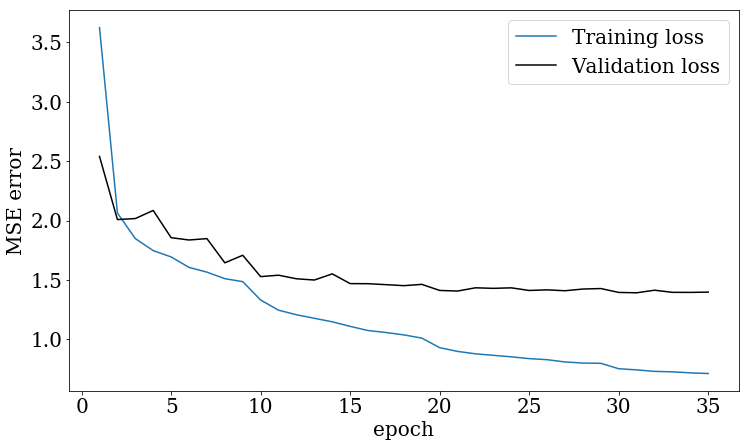

In [10]:
epoch = np.arange(1,epochs+1)
plt.figure(figsize=(12, 7))
plt.rc('font', family='serif')
plt.rc('font', size=20)

plt.plot(epoch,loss_train,label='Training loss')
plt.plot(epoch,loss_val,c='k',label='Validation loss')
plt.xlabel('epoch')
plt.ylabel('MSE error')
plt.legend()

In [16]:
output_test_1 = lstm.predict(inputs_test_1)
output_test_1 = output_test_1.data.numpy()

In [17]:
output_test_2 = lstm.predict(inputs_test_2)
output_test_2 = output_test_2.data.numpy()

In [18]:
output_test_3 = lstm.predict(inputs_test_3)
output_test_3 = output_test_3.data.numpy()

## Post processing step
Go back to coordinate:
We have Vx and Vy and we want x and y.
$ V = d/t$
$ d = V*t$
Here t = 0.4s between each point.
Start from data at index 9. Then we add d_x and d_y to the last x and y.

##### Type 1 trajectory

In [19]:
output_coord_1=np.zeros([11,inputs_test_1.shape[1],2])
for j in range(11):
    for i in range(inputs_test_1.shape[1]):
        if j==0:
            output_coord_1[j,i,0:2] = in_test_coord_1[9,i,0:2]
        else:
            output_coord_1[j,i,0:2] = output_coord_1[j-1,i,0:2]+output_test_1[j-1,i,2:]*0.4
        

In [20]:
dist = np.zeros(inputs_test_1.shape[1])
for i in range(inputs_test_1.shape[1]):
    dist[i] = np.sqrt(sum((gt_test_coord_1[10,i,:]-output_coord_1[10,i,:])**2))

final_coord_error = np.mean(dist)
print('The final distance between the ground trought and the predicted coordinates is :',final_coord_error.round(3))

The final distance between the ground trought and the predicted coordinates is : 1.026


In [21]:
avr = np.zeros((inputs_test_1.shape[1],11))
for i in range(inputs_test_1.shape[1]):
    for j in range(11):
        avr[i,j] = np.sqrt(sum((gt_test_coord_1[j,i,:]-output_coord_1[j,i,:])**2))

average = np.mean(np.mean(avr,1))
print('The average error between the ground trought and the predicted coordinates is :',average.round(3))

The average error between the ground trought and the predicted coordinates is : 0.557


(-0.047163935573156346,
 0.3380505424470689,
 -0.04221019984005976,
 0.886414196641255)

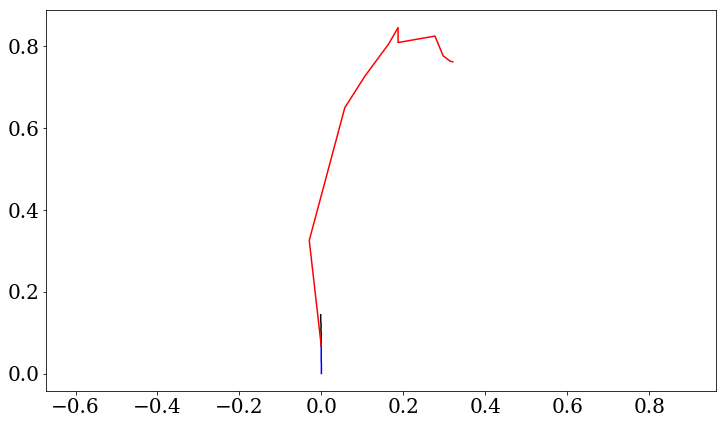

In [22]:
plt.figure(figsize=(12, 7))
plt.rc('font', family='serif')
plt.rc('font', size=20)

ind = np.random.randint(inputs_test_1.shape[1])

plt.plot(in_test_coord_1[:,ind,0],in_test_coord_1[:,ind,1],c='b')
plt.plot(gt_test_coord_1[:,ind,0],gt_test_coord_1[:,ind,1],c='k')
plt.plot(output_coord_1[:,ind,0],output_coord_1[:,ind,1],c='r')
plt.axis('equal')

##### Type 2 trajectory

In [23]:
output_coord_2=np.zeros([11,inputs_test_2.shape[1],2])
for j in range(11):
    for i in range(inputs_test_2.shape[1]):
        if j==0:
            output_coord_2[j,i,0:2] = in_test_coord_2[9,i,0:2]
        else:
            output_coord_2[j,i,0:2] = output_coord_2[j-1,i,0:2]+output_test_2[j-1,i,2:]*0.4
        

In [24]:
dist = np.zeros(inputs_test_2.shape[1])
for i in range(inputs_test_2.shape[1]):
    dist[i] = np.sqrt(sum((gt_test_coord_2[10,i,:]-output_coord_2[10,i,:])**2))

final_coord_error = np.mean(dist)
print('The final distance between the ground truth and the predicted coordinates is :',final_coord_error.round(3))

The final distance between the ground truth and the predicted coordinates is : 0.999


In [25]:
avr = np.zeros((inputs_test_2.shape[1],11))
for i in range(inputs_test_2.shape[1]):
    for j in range(11):
        avr[i,j] = np.sqrt(sum((gt_test_coord_2[j,i,:]-output_coord_2[j,i,:])**2))

average = np.mean(np.mean(avr,1))
print('The average error between the ground truth and the predicted coordinates is :',average.round(3))

The average error between the ground truth and the predicted coordinates is : 0.544


(-0.09331539417701425,
 1.949255777717299,
 -0.27097987206699564,
 5.690577313406909)

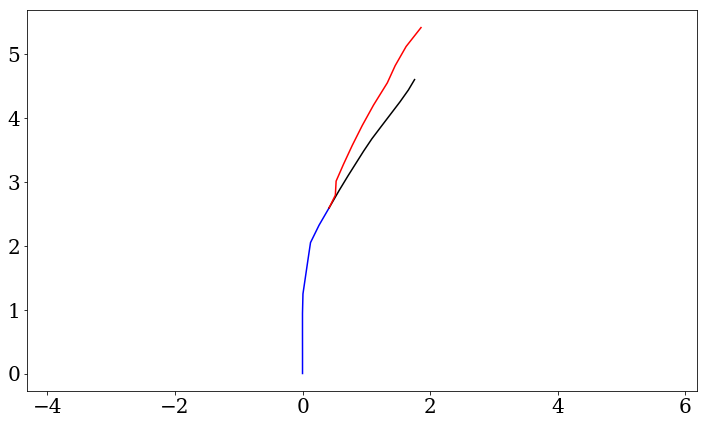

In [26]:
plt.figure(figsize=(12, 7))
plt.rc('font', family='serif')
plt.rc('font', size=20)

ind = np.random.randint(inputs_test_2.shape[1])

plt.plot(in_test_coord_2[:,ind,0],in_test_coord_2[:,ind,1],c='b')
plt.plot(gt_test_coord_2[:,ind,0],gt_test_coord_2[:,ind,1],c='k')
plt.plot(output_coord_2[:,ind,0],output_coord_2[:,ind,1],c='r')
plt.axis('equal')

##### Type 3 trajectory

In [27]:
output_coord_3=np.zeros([11,inputs_test_3.shape[1],2])
for j in range(11):
    for i in range(inputs_test_3.shape[1]):
        if j==0:
            output_coord_3[j,i,0:2] = in_test_coord_3[9,i,0:2]
        else:
            output_coord_3[j,i,0:2] = output_coord_3[j-1,i,0:2]+output_test_3[j-1,i,2:]*0.4
        

In [28]:
dist = np.zeros(inputs_test_3.shape[1])
for i in range(inputs_test_3.shape[1]):
    dist[i] = np.sqrt(sum((gt_test_coord_3[10,i,:]-output_coord_3[10,i,:])**2))

final_coord_error = np.mean(dist)
print('The final distance between the ground truth and the predicted coordinates is :',final_coord_error.round(3))


The final distance between the ground truth and the predicted coordinates is : 1.282


In [29]:
avr = np.zeros((inputs_test_3.shape[1],11))
for i in range(inputs_test_3.shape[1]):
    for j in range(11):
        avr[i,j] = np.sqrt(sum((gt_test_coord_3[j,i,:]-output_coord_3[j,i,:])**2))

average = np.mean(np.mean(avr,1))
print('The average error between the ground trought and the predicted coordinates is :',average.round(3))

The average error between the ground trought and the predicted coordinates is : 0.638


In [1]:
plt.figure(figsize=(12, 7))
plt.rc('font', family='serif')
plt.rc('font', size=20)

ind = 0#np.random.randint(inputs_test_3.shape[1])

plt.plot(in_test_coord_3[:,ind,0],in_test_coord_3[:,ind,1],c='b')
plt.plot(gt_test_coord_3[:,ind,0],gt_test_coord_3[:,ind,1],c='k')
plt.plot(output_coord_3[:,ind,0],output_coord_3[:,ind,1],c='r')
plt.axis('equal')

NameError: name 'plt' is not defined

In [31]:
import torch
print(torch.__version__)

0.4.0


In [34]:
var = [[[0, 1, -4, 8],
       [2, -3, 2, 1],
       [5, -8, 7, 1]],[[0, 1, -4, 8],
       [2, -3, 2, 1],
       [5, -8, 7, 1]]]

var = torch.Tensor(var)

In [35]:
var.shape

torch.Size([2, 3, 4])

In [36]:
index = torch.LongTensor([1,0,2])

In [37]:
index.shape

torch.Size([3])

In [89]:
n = np.arange(480).reshape((4,24,5))
a = torch.from_numpy(n)
a.type=float
a.shape

torch.Size([4, 24, 5])

In [90]:
b = torch.zeros(a.shape[1],a.shape[0],a.shape[2])
b.shape


torch.Size([24, 4, 5])

In [103]:
def mypermute(a):
    b = torch.zeros(a.shape[1],a.shape[0],a.shape[2])  
    for i in range(a.shape[0]):
        for j in range(a.shape[2]):
            b[:,i,j]=a[i,:,j]
    for i in range(a.shape[1]):
        for j in range(a.shape[2]):
            b[i,:,j]=a[:,i,j]
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            b[j,i,:]=a[i,j,:]
    return b


In [104]:
a = mypermute(a)

In [106]:
a[5,:,4]

tensor([  29.,  149.,  269.,  389.])

In [101]:
b[5,:,4]

tensor([  29.,  149.,  269.,  389.])